In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [21]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [22]:
# HIDDEN
df = pd.read_csv('water_large.csv')

In [23]:
# HIDDEN
from collections import namedtuple
Curve = namedtuple('Curve', ['xs', 'ys'])

def flatten(seq): return [item for subseq in seq for item in subseq]

def make_curve(clf, x_start=-50, x_end=50):
    xs = np.linspace(x_start, x_end, num=100)
    ys = clf.predict(xs.reshape(-1, 1))
    return Curve(xs, ys)

def plot_data(df=df, ax=plt, **kwargs):
    ax.scatter(df.iloc[:, 0], df.iloc[:, 1], s=50, **kwargs)

def plot_curve(curve, ax=plt, **kwargs):
    ax.plot(curve.xs, curve.ys, **kwargs)
    
def plot_curves(curves, cols=2, labels=None):
    if labels is None:
        labels = [f'Deg {deg} poly' for deg in degrees]
    rows = int(np.ceil(len(curves) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8),
                             sharex=True, sharey=True)
    for ax, curve, label in zip(flatten(axes), curves, labels):
        plot_data(ax=ax, label='Training data')
        plot_curve(curve, ax=ax, label=label)
        ax.set_ylim(-5e10, 170e10)
        ax.legend()
        
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off',
                    left='off', right='off')
    plt.grid(False)
    plt.title('Polynomial Regression')
    plt.xlabel('Water Level Change (m)')
    plt.ylabel('Water Flow (Liters)')
    plt.tight_layout()
    

In [24]:
# HIDDEN
def coefs(clf):
    reg = clf.named_steps['reg']
    return np.append(reg.intercept_, reg.coef_)

def coef_table(clf):
    vals = coefs(clf)
    return (pd.DataFrame({'Coefficient Value': vals})
            .rename_axis('degree'))

In [25]:
# HIDDEN
X = df.iloc[:, [0]].as_matrix()
y = df.iloc[:, 1].as_matrix()

degrees = [1, 2, 8, 12]
clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                  ('reg', LinearRegression())])
        .fit(X, y)
        for deg in degrees]

curves = [make_curve(clf) for clf in clfs]

alphas = [0.01, 0.1, 1.0, 10.0]

ridge_clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                        ('reg', RidgeCV(alphas=alphas, normalize=True))])
        .fit(X, y)
        for deg in degrees]

ridge_curves = [make_curve(clf) for clf in ridge_clfs]

## L2 Regularization: Ridge Regression

In this section we introduce $ L_2 $ regularization, a method of penalizing large weights in our cost function to lower model variance. We briefly review linear regression, then introduce regularization as a modification to the cost function.

To perform least squares linear regression, we use the model:

$$
f_\hat{\theta}(x) = \hat{\theta} \cdot x
$$

We fit the model by minimizing the mean squared error cost function:

$$
\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}^n(y_i - f_\hat{\theta} (X_i))^2\\
\end{aligned}
$$

In the above definitions, $ X $ represents the $ n \times p $ data matrix, $ x $ represents a row of $ X $, $ y $ represents the observed outcomes, and $ \hat{\theta} $ represents the model weights.

## L2 Regularization Definition

To add $ L_2 $ regularization to the model, we modify the cost function above:

$$
\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}(y_i - f_\hat{\theta} (X_i))^2
    + \lambda \sum_{j = 1}^{p} \hat{\theta_j}^2
\end{aligned}
$$

Notice that the cost function above is the same as before with the addition of the $ L_2 $ regularization $ \lambda \sum_{j = 1}^{p} \hat{\theta_j}^2 $ term. The summation in this term sums the square of each model weight $ \hat{\theta_1}, \hat{\theta_2}, \ldots, \hat{\theta_p} $. The term also introduces a new scalar model parameter $ \lambda $ that adjusts the regularization penalty.

The regularization term causes the cost to increase if the values in $ \hat{\theta} $ are further away from 0. With the addition of regularization, the optimal model weights minimize the combination of loss and regularization penalty rather than the loss alone. Since the resulting model weights tend to be smaller in absolute value, the model has lower variance and higher bias.

Using $ L_2 $ regularization with a linear model and the mean squared error cost function is also known more commonly as **ridge regression**.

### The Regularization Parameter

The regularization parameter $ \lambda $ controls the regularization penalty. A small $ \lambda $ results in a small penalty—if $ \lambda = 0 $ the regularization term is also $ 0 $ and the cost is not regularized at all.

A large $ \lambda $ terms results in a large penalty and therefore a simpler model. Increasing $ \lambda $ decreases the variance and increases the bias of the model. We use cross-validation to select the value of $ \lambda $ that minimizes the validation error.

**Note about regularization in `scikit-learn`:**

`scikit-learn` provides regression models that have regularization built-in. For example, to conduct ridge regression you may use the [`sklearn.linear_model.Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) regression model. Note that `scikit-learn` models call the regularization parameter `alpha` instead of $ \lambda $.

`scikit-learn` conveniently provides regularized models that perform cross-validation to select a good value of $ \lambda $. For example, the [`sklearn.linear_model.RidgeCV`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) allows users to input regularization parameter values and will automatically use cross-validation to select the parameter value with the least validation error.

### Bias Term Exclusion

Note that the bias term $ \theta_0 $ is not included in the summation of the regularization term. We do not penalize the bias term because increasing the bias term does not increase the variance of our model—the bias term simply shifts all predictions by a constant value.

### Data Normalization

Notice that the regularization term $ \lambda \sum_{j = 1}^{p} \hat{\theta_j}^2 $ penalizes each $ \hat{\theta_j} $ equally. However, the effect of each $ \hat{\theta_j} $ differs depending on the data itself. Consider this section of the water flow dataset after adding degree 8 polynomial features:

In [26]:
# HIDDEN
pd.DataFrame(clfs[2].named_steps['poly'].transform(X[:5]),
             columns=[f'deg_{n}_feat' for n in range(8)])

,deg_0_feat,deg_1_feat,...,deg_6_feat,deg_7_feat
0,-15.94,253.98,...,-261095791.08,4161020472.12
1,-29.15,849.90,...,-17897014961.65,521751305227.70
2,36.19,1309.68,...,81298431147.09,2942153527269.12
3,37.49,1405.66,...,104132296999.30,3904147586408.71
4,-48.06,2309.65,...,-592123531634.12,28456763821657.78


We can see that the degree 7 polynomial features have much larger values than the degree 1 features. This means that a large model weight for the degree 7 features affects the predictions much more than a large model weight for the degree 1 features. If we apply regularization to this data directly, the regularization penalty will disproportionately lower the model weight for the lower degree features. In practice, this often results in high model variance even after applying regularization since the features with large effect on prediction will not be affected.

To combat this, we *normalize* each data column by subtracting the mean and scaling the values in each column to be between -1 and 1. In `scikit-learn`, most regression models allow initializing with `normalize=True` to normalize the data before fitting.

Another analogous technique is *standardizing* the data columns by subtracting the mean and dividing by the standard deviation for each data column.

## Using Ridge Regression

We have previously used polynomial features to fit polynomials of degree 2, 8, and 12 to water flow data. The original data and resulting model predictions are repeated below.

In [27]:
# HIDDEN
df

,water_level_change,water_flow
0,-15.94,60422330445.52
1,-29.15,33214896575.60
2,36.19,972706380901.06
...,...,...
20,7.09,236352046523.78
21,46.28,1494256381086.73
22,14.61,378146284247.97


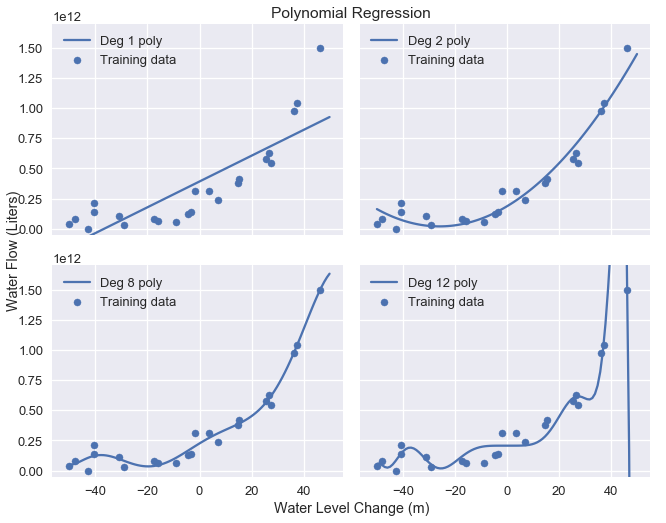

In [28]:
# HIDDEN
plot_curves(curves)

To conduct ridge regression, we first extract the data matrix and the vector of outcomes from the data:

In [29]:
X = df.iloc[:, [0]].as_matrix()
y = df.iloc[:, 1].as_matrix()
print('X: ')
print(X)
print()
print('y: ')
print(y)

X: 
[[-15.94]
 [-29.15]
 [ 36.19]
 ...
 [  7.09]
 [ 46.28]
 [ 14.61]]

y: 
[6.04e+10 3.32e+10 9.73e+11 ... 2.36e+11 1.49e+12 3.78e+11]


Then, we apply a degree 12 polynomial transform to `X`:

In [30]:
from sklearn.preprocessing import PolynomialFeatures

# We need to specify include_bias=False since sklearn's classifiers
# automatically add the intercept term.
X_poly_8 = PolynomialFeatures(degree=8, include_bias=False).fit_transform(X)
print('First two rows of transformed X:')
print(X_poly_8[0:2])

First two rows of transformed X:
[[-1.59e+01  2.54e+02 -4.05e+03  6.45e+04 -1.03e+06  1.64e+07 -2.61e+08
   4.16e+09]
 [-2.92e+01  8.50e+02 -2.48e+04  7.22e+05 -2.11e+07  6.14e+08 -1.79e+10
   5.22e+11]]


We specify `alpha` values that `scikit-learn` will select from using cross-validation, then use the `RidgeCV` classifier to fit the transformed data.

In [31]:
from sklearn.linear_model import RidgeCV

alphas = [0.01, 0.1, 1.0, 10.0]

# Remember to set normalize=True to normalize data
clf = RidgeCV(alphas=alphas, normalize=True).fit(X_poly_8, y)

# Display the chosen alpha value:
clf.alpha_

0.1

Finally, we plot the model predictions for the base degree 8 polynomial classifier next to the regularized degree 8 classifier:

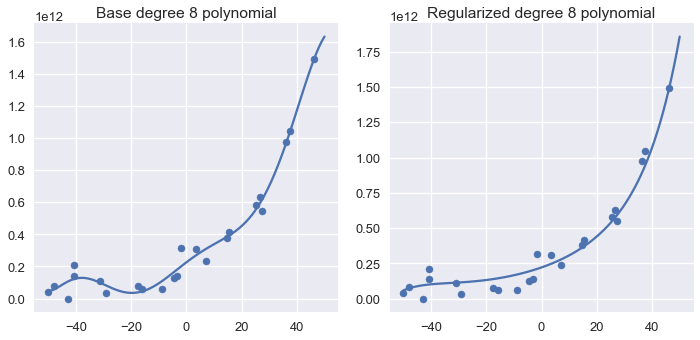

In [32]:
# HIDDEN
fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plot_data()
plot_curve(curves[2])
plt.title('Base degree 8 polynomial')

plt.subplot(122)
plot_data()
plot_curve(ridge_curves[2])
plt.title('Regularized degree 8 polynomial')
plt.tight_layout()

We can see that the regularized polynomial is smoother than the base degree 8 polynomial and still captures the major trend in the data.

Comparing the coefficients of the non-regularized and regularized models shows that ridge regression favors placing model weights on the lower degree polynomial terms:

In [33]:
# HIDDEN
base = coef_table(clfs[2]).rename(columns={'Coefficient Value': 'Base'})
ridge = coef_table(ridge_clfs[2]).rename(columns={'Coefficient Value': 'Regularized'})

pd.options.display.max_rows = 20
display(base.join(ridge))
pd.options.display.max_rows = 7

,Base,Regularized
degree,,
0,225782472111.94,221063525725.23
1,13115217770.78,6846139065.96
2,-144725749.98,146158037.96
3,-10355082.91,1930090.04
4,567935.23,38240.62
5,9805.14,564.21
6,-249.64,7.25
7,-2.09,0.18
8,0.03,0.00


Repeating the process for degree 12 polynomial features results in a similar result:

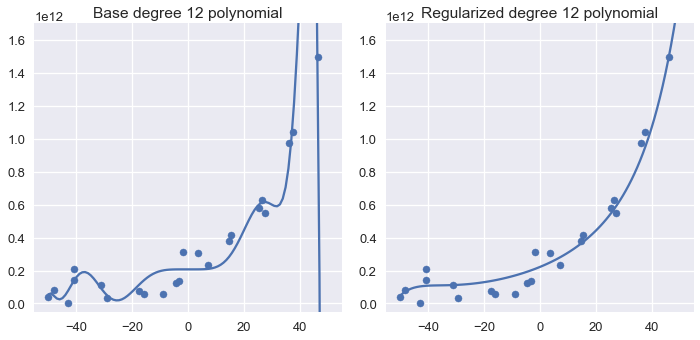

In [34]:
# HIDDEN
fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plot_data()
plot_curve(curves[3])
plt.title('Base degree 12 polynomial')
plt.ylim(-5e10, 170e10)

plt.subplot(122)
plot_data()
plot_curve(ridge_curves[3])
plt.title('Regularized degree 12 polynomial')
plt.ylim(-5e10, 170e10)
plt.tight_layout()

Increasing the regularization parameter results in progressively simpler models. The plot below demonstrates the effects of increasing the regularization amount from 0.001 to 100.0.

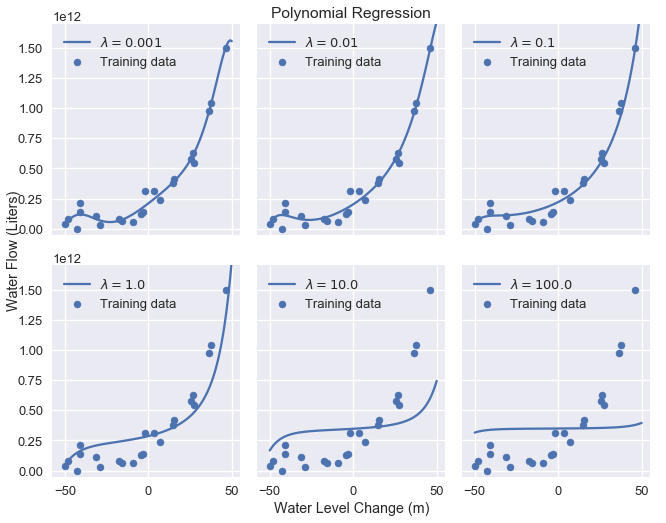

In [35]:
# HIDDEN
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

alpha_clfs = [Pipeline([
    ('poly', PolynomialFeatures(degree=12, include_bias=False)),
    ('reg', Ridge(alpha=alpha, normalize=True))]
).fit(X, y) for alpha in alphas]

alpha_curves = [make_curve(clf) for clf in alpha_clfs]
labels = [f'$\\lambda = {alpha}$' for alpha in alphas]

plot_curves(alpha_curves, cols=3, labels=labels)

As we can see, increasing the regularization parameter increases the bias of our model. If our parameter is too large, the model becomes a constant model because any non-zero model weight is heavily penalized.

## Summary

Using $ L_2 $ regularization allows us to tune model bias and variance by penalizing large model weights. $ L_2 $ regularization for least squares linear regression is also known by the more common name ridge regression. Using regularization adds an additional model parameter $ \lambda $ that we adjust using cross-validation.